In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.nn import init
import time

In [2]:
# dataloader arguments
batch_size = 128
data_path='./kmnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.KMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.KMNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

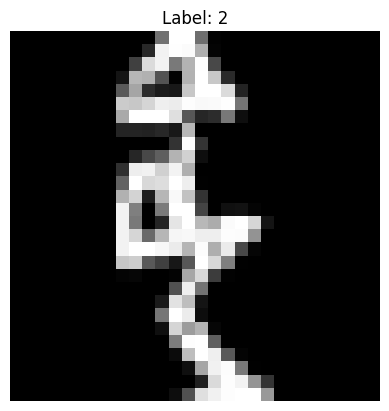

In [8]:
data, target = next(iter(train_loader))
i=10
plt.imshow(data[i][0], cmap='gray')
plt.title(f'Label: {target[i].item()}')
plt.axis('off')
plt.show()

In [3]:
# Network Architecture
num_inputs = 28*28
num_hidden = 2000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

def generate_spike(x):
    data_input = x.view(128,-1)
    spk_input = []
    for batch in range(128):
        spk_input_batch = spikegen.rate(data_input[batch], num_steps = 25)
        spk_input.append(spk_input_batch)
    return torch.stack(spk_input, dim = 1)

In [4]:
num_epochs = 1
loss_hist = []

start_time = time.time()

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    train_accuracy_hist = []
    test_accuracy_hist = []
    
    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(generate_spike(data))

        max_value, max_index = torch.max(spk_rec.sum(dim = 0),dim = 1)
        train_accuracy = (max_index==targets).sum()/128
        train_accuracy_hist.append(train_accuracy)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # another loss
        # idx = spk_rec.sum(dim=0)
        # loss_val = loss(idx, targets)
        # test my net
        num_epochs = 1
        test_result = []
        test_tgt = []
        test_loss_hist = []
        # test loop
        for epoch in range(num_epochs):
            iter_counter_test = 0
            test_batch = iter(test_loader)
            # Test set
            with torch.no_grad():
                net.eval()
                for test_data, test_targets in test_batch:
                    test_data = test_data.to(device)
                    test_targets = test_targets.to(device)
                    # Test set forward pass
                    test_spk, test_mem = net(generate_spike(test_data))
                    # Test set loss
                    test_loss = torch.zeros((1), dtype=dtype, device=device)
                    for step in range(num_steps):
                        test_loss += loss(test_mem[step], test_targets)
                    test_loss_hist.append(test_loss.item())
                    
                    test_tgt.append(test_targets)
                    _, idx = test_spk.sum(dim=0).max(1)
                    test_result.append(idx)
        
                    iter_counter_test += 1
                    if iter_counter_test == 50:
                        break
                        
        testacc = sum(torch.stack(test_result, dim=0).reshape(-1) == torch.stack(test_tgt, dim=0).reshape(-1))/6400
        test_accuracy_hist.append(testacc)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        iter_counter += 1
        if iter_counter == 400:
            break

end_time = time.time()

In [7]:
elapsed_time = end_time - start_time
print(f"操作所花费的时间为: {elapsed_time} 秒")

操作所花费的时间为: 7802.160377025604 秒


In [11]:
# 将列表转换为 NumPy 数组
arr0 = np.array(loss_hist)

# 保存数组到 .npy 文件
np.save('train_loss_sg_kmnist.npy', arr0)

# 将列表转换为 NumPy 数组
arr1 = np.array(train_accuracy_hist)

# 保存数组到 .npy 文件k
np.save('train_accuracy_sg_kmnist.npy', arr1)

# 将列表转换为 NumPy 数组
arr2 = np.array(test_accuracy_hist)

# 保存数组到 .npy 文件
np.save('test_accuracy_sg_kmnist.npy', arr2)

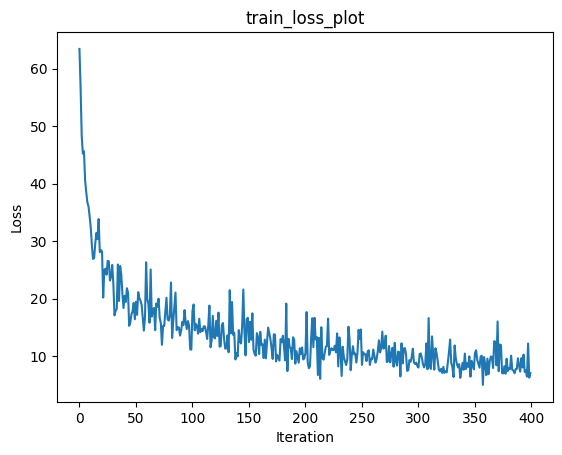

In [13]:
plt.plot(loss_hist)
plt.title("train_loss_plot")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

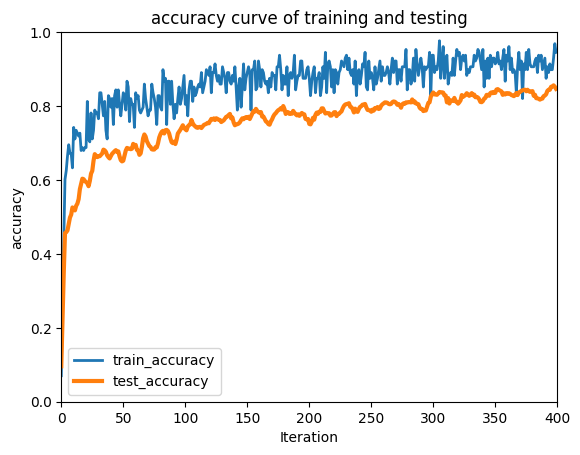

In [14]:
plt.plot(train_accuracy_hist,label = "train_accuracy", linewidth = 2)
plt.plot(test_accuracy_hist, label = "test_accuracy", linewidth = 3)
plt.title("accuracy curve of training and testing")
plt.xlim((0,400))
plt.ylim((0,1))
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("accuracy")
plt.show()

In [20]:
num_epochs = 1
test_result = []
test_tgt = []
test_loss_hist = []
# test loop
for epoch in range(num_epochs):
    iter_counter = 0
    test_batch = iter(test_loader)
    # Test set
    with torch.no_grad():
        net.eval()
        for test_data, test_targets in test_batch:
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            # Test set forward pass
            test_spk, test_mem = net(generate_spike(test_data))
            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            
            test_tgt.append(test_targets)
            _, idx = test_spk.sum(dim=0).max(1)
            test_result.append(idx)

            iter_counter += 1
            if iter_counter == 50:
                break

In [21]:
sum(torch.stack(test_result, dim=0).reshape(-1) == torch.stack(test_tgt, dim=0).reshape(-1))/6400

tensor(0.8444)

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(test_loss_hist)
plt.title("test Loss Curves")
plt.legend(["test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [68]:
# total = 0
# correct = 0

# # drop_last switched to False to keep all samples
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# with torch.no_grad():
#   net.eval()
#   for data, targets in test_loader:
#     data = data.to(device)
#     targets = targets.to(device)

#     # forward pass
#     test_spk, _ = net(generate_spike(data))

#     # calculate total accuracy
#     _, predicted = test_spk.sum(dim=0).max(1)
#     total += targets.size(0)
#     correct += (predicted == targets).sum().item()